In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from collections import Counter

In [2]:
# Path to dataset
dataset_path = '/kaggle/input/animal-dataset/animal_dataset'

# Parameters
img_size = (32, 32)

images = []
labels = []

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = imread(img_path)
            if img.ndim == 3:
                img = rgb2gray(img)  # Convert to grayscale
            img_resized = resize(img, img_size)
            images.append(img_resized.flatten())  # Flatten to 1D vector
            labels.append(class_folder)

# Convert to arrays
X = np.array(images)
y = np.array(labels)

# Encode labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [3]:
def knn_predict(X_train, y_train, X_test, k=3, distance_metric='euclidean'):
    predictions = []
    for test_sample in X_test:
        # Compute distances
        if distance_metric == 'euclidean':
            distances = np.linalg.norm(X_train - test_sample, axis=1)
        elif distance_metric == 'manhattan':
            distances = np.sum(np.abs(X_train - test_sample), axis=1)
        else:
            raise ValueError("Distance metric must be 'euclidean' or 'manhattan'")

        # Find k nearest neighbors
        nearest_indices = np.argsort(distances)[:k]
        nearest_labels = y_train[nearest_indices]

        # Majority vote
        most_common = Counter(nearest_labels).most_common(1)[0][0]
        predictions.append(most_common)

    return np.array(predictions)


In [4]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
k_values = [1, 3, 5, 7, 9]  # Example values of K
distances = ['euclidean', 'manhattan']

# Store average accuracies
avg_accuracies = {d: [] for d in distances}

for d in distances:
    for k in k_values:
        fold_accuracies = []
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y_encoded[train_index], y_encoded[val_index]

            y_pred = knn_predict(X_train, y_train, X_val, k=k, distance_metric=d)
            acc = accuracy_score(y_val, y_pred)
            fold_accuracies.append(acc)

        avg_accuracy = np.mean(fold_accuracies)
        avg_accuracies[d].append(avg_accuracy)
        print(f"Distance: {d}, K={k}, Accuracy={avg_accuracy:.4f}")


Distance: euclidean, K=1, Accuracy=0.3733
Distance: euclidean, K=3, Accuracy=0.3867
Distance: euclidean, K=5, Accuracy=0.4167
Distance: euclidean, K=7, Accuracy=0.4000
Distance: euclidean, K=9, Accuracy=0.4433
Distance: manhattan, K=1, Accuracy=0.4033
Distance: manhattan, K=3, Accuracy=0.4233
Distance: manhattan, K=5, Accuracy=0.4500
Distance: manhattan, K=7, Accuracy=0.4167
Distance: manhattan, K=9, Accuracy=0.4600


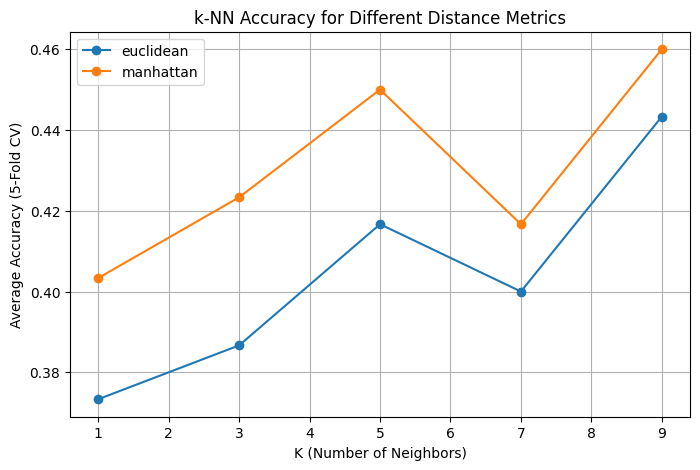

In [5]:
plt.figure(figsize=(8,5))
for d in distances:
    plt.plot(k_values, avg_accuracies[d], marker='o', label=d)
plt.title("k-NN Accuracy for Different Distance Metrics")
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Average Accuracy (5-Fold CV)")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
test_path = "/kaggle/input/animal-dataset/animal_dataset"  # Same dataset as example
test_images = []
test_filenames = []

for class_folder in os.listdir(test_path):
    class_path = os.path.join(test_path, class_folder)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = imread(img_path)
                if img.ndim == 3:
                    img = rgb2gray(img)
                img_resized = resize(img, img_size, anti_aliasing=True)
                test_images.append(img_resized.flatten())
                test_filenames.append(img_file)
            except:
                continue

X_test = np.array(test_images)

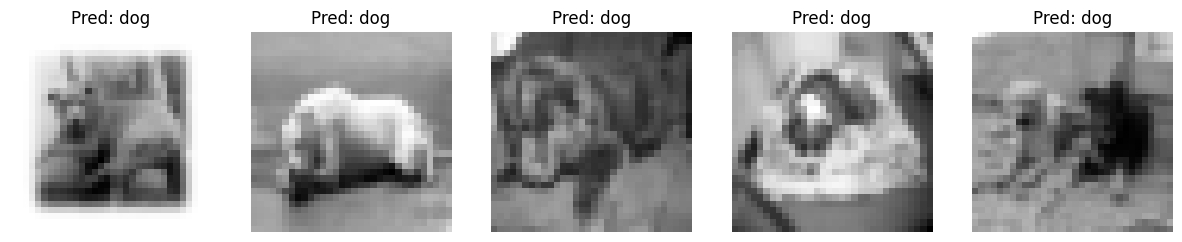

In [13]:
import matplotlib.pyplot as plt

top_n = min(5, len(X_test))

plt.figure(figsize=(15,3))
for i in range(top_n):
    img = X_test[i].reshape(img_size)  # reshape back to 2D
    pred_label = y_test_pred_labels[i]
    
    plt.subplot(1, top_n, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {pred_label}")
    plt.axis('off')

plt.show()

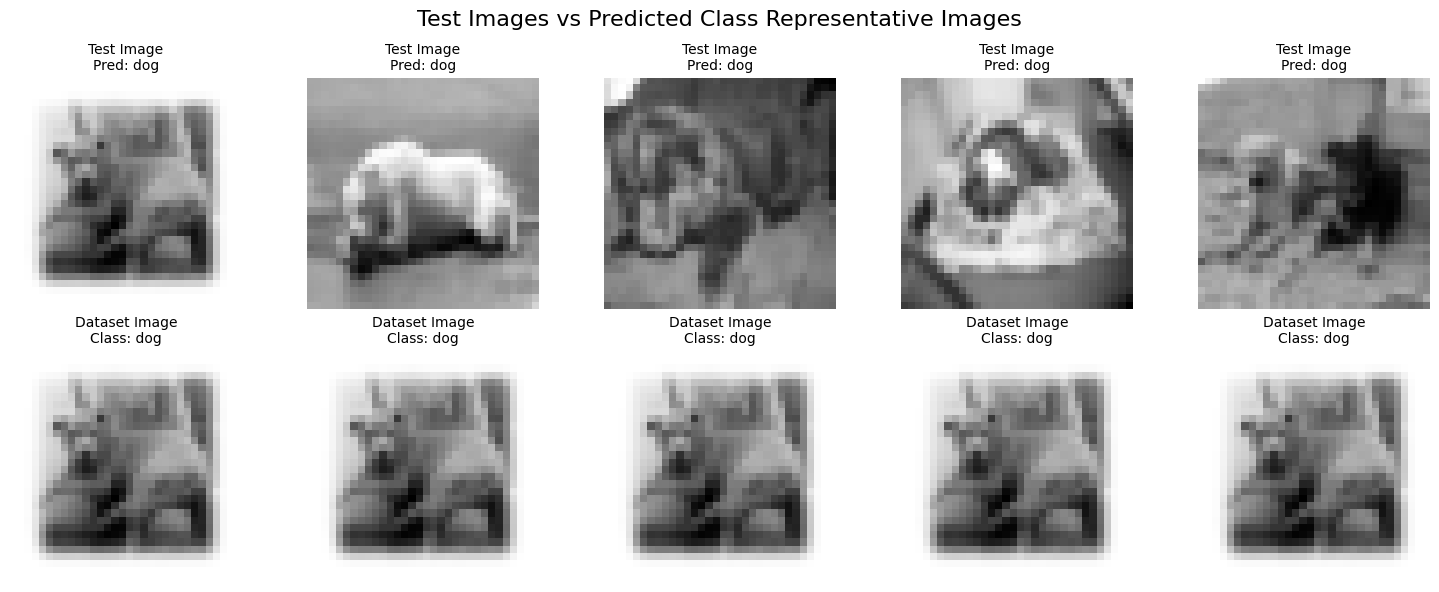

In [17]:
import matplotlib.pyplot as plt
import numpy as np

top_n = min(5, len(X_test))

plt.figure(figsize=(15, 6))

for i in range(top_n):
    # --- Test image ---
    img = X_test[i].reshape(img_size)
    pred_label = y_test_pred_labels[i]
    
    # Get a representative image from the predicted class
    pred_class_idx = np.where(y_encoded == le.transform([pred_label])[0])[0][0]
    pred_class_img = X[pred_class_idx].reshape(img_size)
    
    # --- Show test image ---
    plt.subplot(2, top_n, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Test Image\nPred: {pred_label}", fontsize=10)
    plt.axis('off')
    
    # --- Show predicted class image from dataset ---
    plt.subplot(2, top_n, top_n + i + 1)
    plt.imshow(pred_class_img, cmap='gray')
    plt.title(f"Dataset Image\nClass: {pred_label}", fontsize=10)
    plt.axis('off')

plt.suptitle("Test Images vs Predicted Class Representative Images", fontsize=16)
plt.tight_layout()
plt.show()
